In [1]:
# Author : Himanshu Patel(), Nitish Singh(935065403), Nakul Sahayata(396353817)
# Course : CIS 600 − Data Mining and Social Media 
# Final Project : Hate Speech Detection
# Date : 12/14/2018

# Importing Packages

In [2]:
# import packages
import numpy as np
import pandas as pd
import tweepy
from tweepy import API
from tweepy import Cursor
from tweepy.streaming import StreamListener # With this we can listen to Tweets based on certain keywords and hashtags
from tweepy import OAuthHandler # Responsible for Authenticating for some of the authenticating credentials stored in TwitterCredentials.py file
from tweepy import Stream
import TwitterCredential
from bokeh.layouts import column
from flask import request
from flask import Flask, render_template, session, redirect
from werkzeug.wrappers import Request, Response
from flask import Flask
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
import re
import threading
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import random
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob


# Initializing the three classifiers
svc = LinearSVC()
nb = MultinomialNB()
lr = LogisticRegression()
%matplotlib inline

# Importing dataset

In [3]:
# Importing dataset
df1 = pd.read_csv('resources/train.csv', usecols=['Insult','Comment'])
print(df1.head(10))
df2 = pd.read_csv('resources/test_with_solutions.csv', usecols=['Insult','Comment'])
print(df2.head(10))
# Merging two datasets together
df = df1.append(df2, ignore_index=True)
# importing third dataset from github repository
df3 = pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')
df3 = df3.drop(df3.columns[[0,1,2,3,4]],axis=1)
print(df3.head(10))
# changing the column labels
df3['class'] = df3['class'].map({0:1 , 1:1, 2:0})
df3.columns = ['Insult','Comment']

   Insult                                            Comment
0       1                               "You fuck your dad."
1       0  "i really don't understand your point.\xa0 It ...
2       0  "A\\xc2\\xa0majority of Canadians can and has ...
3       0  "listen if you dont wanna get married to a man...
4       0  "C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...
5       0  "@SDL OK, but I would hope they'd sign him to ...
6       0                      "Yeah and where are you now?"
7       1  "shut the fuck up. you and the rest of your fa...
8       1  "Either you are fake or extremely stupid...may...
9       1  "That you are an idiot who understands neither...
   Insult                                            Comment
0       0  "THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...
1       0  "@ian21\xa0"Roger Clemens is the fucking man, ...
2       1  "Agree with Alan you are an extremest idiot.  ...
3       0  "Really?\\n\\nI see Marc Lamont Hill on variou...
4       0  "Really suck 

In [4]:
# Merging all three datasets to get the final dataset which will go through data cleaning
df_final = df.append(df3, ignore_index=True)

In [5]:
df_final = df_final.sample(frac=1,axis=1).sample(frac=1).reset_index(drop=True)
print(df_final.head(10))

                                             Comment  Insult
0  will u love dat nigga even if he lose it all.....       1
1  Man talk to em RT @StraightCash08: Of course n...       0
2  RT @PRAYINGFORGEMS: the timeline boring becaus...       1
3  YES!! RT @Merky__: NO!!! RT @HuffPostTaste Wil...       0
4  RT @DipOnline If K Michelle was apart of Balti...       1
5  RT @iAMxJONES: I know where I would be tonight...       1
6  RT @Beeetzzz: I feel bad for guys that give th...       1
7         @TheBovee @Mr_Astonishing we outchea bitch       1
8                          "Like you Know Fck Face."       1
9  RT @DarrionDaDon_: Kobe: "That's why yo man wa...       1


# Data Cleaning

In [6]:
tok = WordPunctTokenizer()
# for removing usernames
ignore_list = ['rt', 'xa', 'da', 're']
pat1 = r'@[A-Za-z0-9]+'
# removing hyperlinks
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
# for reading the negation words correctly
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
# helper function to clean the text
def text_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped        
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) >= 1 and x not in ignore_list]
    return (" ".join(words)).strip()

In [7]:
clean_texts = []
for i in range(len(df_final.Comment)):
    clean_texts.append(text_cleaner(df_final['Comment'][i]))

In [8]:
# cleaned dataset
clean_df = pd.DataFrame(clean_texts, columns = ['text'])
clean_df['Insult'] = df_final['Insult']
print(clean_df.head(10))

                                                text  Insult
0  will u love dat nigga even if he lose it all o...       1
1  man talk to em of course nothing is wrong with...       0
2  the timeline boring because all the hoes out r...       1
3  yes no will you buy the new caramel apple flav...       0
4  if k michelle was apart of baltimore twitter s...       1
5  i know where i would be tonight if i was in at...       1
6  i feel bad for guys that give their girlfriend...       1
7                       astonishing we outchea bitch       1
8                             like you know fck face       1
9  kobe that s why yo man want me hoe guy holding...       1


# Word Cloud

In [9]:
ignore_list = ['rt', 'xa', 'da', 're']

In [10]:
neg_tweets = clean_df[clean_df['Insult']==1]
neg_string = []
for t in neg_tweets.text:
        neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

# Split the String into the words
tokens = word_tokenize(neg_string)
tokens = [w for w in tokens if not w in (stopwords.words('english') and ignore_list)]
random.shuffle(tokens)
lemma = nltk.wordnet.WordNetLemmatizer()
neg_string = []
for word in tokens:
    neg_string.append(lemma.lemmatize(word))
neg_string = pd.Series(neg_string).str.cat(sep=' ')


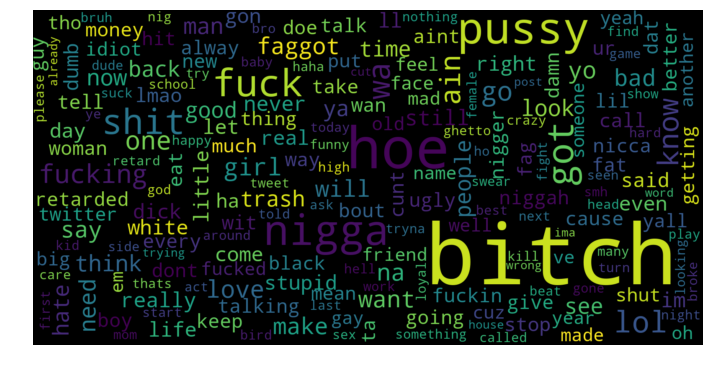

In [11]:
# Configuring word cloud
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Train / Dev / Test Split

In [12]:
X = clean_df.text
y = clean_df.Insult

In [13]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.2, random_state=0)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, 
                                                              test_size=.5, random_state=0)

In [14]:
print ("Train set has total {0} entries with {1:.2f}% neutral, {2:.2f}% negative".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% neutral, {2:.2f}% negative".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% neutral, {2:.2f}% negative".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 25101 entries with 28.60% neutral, 71.40% negative
Validation set has total 3138 entries with 29.86% neutral, 70.14% negative
Test set has total 3138 entries with 28.68% neutral, 71.32% negative


# Sentiment Analysis using TextBlob

In [15]:
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

In [16]:
print(confusion_matrix(y_validation, tbpred, labels=[1,0]))

[[1425  776]
 [ 698  239]]


In [17]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['negative', 'neutral'],
                         columns=['predicted_negative','predicted_neutral'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 53.03%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_neutral
negative                1425                776
neutral                  698                239
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

          0       0.24      0.26      0.24       937
          1       0.67      0.65      0.66      2201

avg / total       0.54      0.53      0.54      3138



# Accuracy Summary

In [18]:
# helper function - accuracy_summary
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
        
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    return accuracy

# Feature Extraction using Count Vectorizer and Tf-idf

In [19]:
cvec = CountVectorizer()
tvec = TfidfVectorizer()
n_features = np.arange(17000,60000,5000)
# helper function - accuracy checker for n features
def nfeature_accuracy_checker(vectorizer=cvec, min_df=1,n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(min_df=min_df,stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result, checker_pipeline

# Accuracy using Tf-idf and LinearSVC

In [20]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
svc_feature_result_wosw, svc_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,stop_words='english',classifier=svc)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.73%
model is 20.59% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.63%
model is 20.49% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.82%
model is 20.68% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.89%
model is 20.75% more accur

In [21]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
svc_feature_result_ug, svc_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=svc)

RESULT FOR UNIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.76%
model is 20.62% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.85%
model is 20.71% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.63%
model is 20.49% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.73%
model is 20.59% more accurate

In [22]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
svc_feature_result_bg, svc_b_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=svc,min_df=2,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.54%
model is 20.40% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.76%
model is 20.62% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.66%
model is 20.52% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.54%
model is 20.40% more accurate 

In [23]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
svc_feature_result_tg, svc_t_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=svc,min_df=2,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.41%
model is 20.27% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.31%
model is 20.17% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.54%
model is 20.40% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.50%
model is 20.36% more accurate

# Accuracy using Tf-idf and Multinomial Naive Byes

In [24]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
# nb_feature_result_wosw, nb_u_checker_pipeline = nfeature_accuracy_checker(stop_words='english',classifier=nb,n_features=np.arange(17000,30000,3000))
nb_feature_result_wosw, nb_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,stop_words='english',classifier=nb)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 81.10%
model is 10.96% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 79.83%
model is 9.69% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 79.09%
model is 8.95% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 78.59%
model is 8.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 70.

In [25]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
nb_feature_result_ug, nb_u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=nb)

RESULT FOR UNIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 79.70%
model is 9.56% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 78.30%
model is 8.16% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 77.06%
model is 6.92% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 76.67%
model is 6.53% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 70.14%


In [26]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
nb_feature_result_bg, nb_b_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=nb,min_df=2,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 83.81%
model is 13.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 83.49%
model is 13.35% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 83.01%
model is 12.87% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 82.06%
model is 11.92% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 70.1

In [27]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
nb_feature_result_tg, nb_t_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,classifier=nb,min_df=2,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 84.35%
model is 14.21% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 83.84%
model is 13.70% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 83.72%
model is 13.58% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 83.01%
model is 12.87% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 70.

# Accuracy using Tf-idf and Linear Regression

In [28]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec,stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 91.43%
model is 21.29% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 91.40%
model is 21.26% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 91.46%
model is 21.32% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%

In [29]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.54%
model is 20.40% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.31%
model is 20.17% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.25%
model is 20.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
ac

In [30]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg, b_checker_pipeline = nfeature_accuracy_checker(min_df=2,vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.06%
model is 19.92% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 89.99%
model is 19.85% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.06%
model is 19.92% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
acc

In [31]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg, t_checker_pipeline = nfeature_accuracy_checker(min_df=2,vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 89.93%
model is 19.79% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 89.80%
model is 19.66% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 89.83%
model is 19.69% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
ac

# Accuracy Comparision using Tf-idf

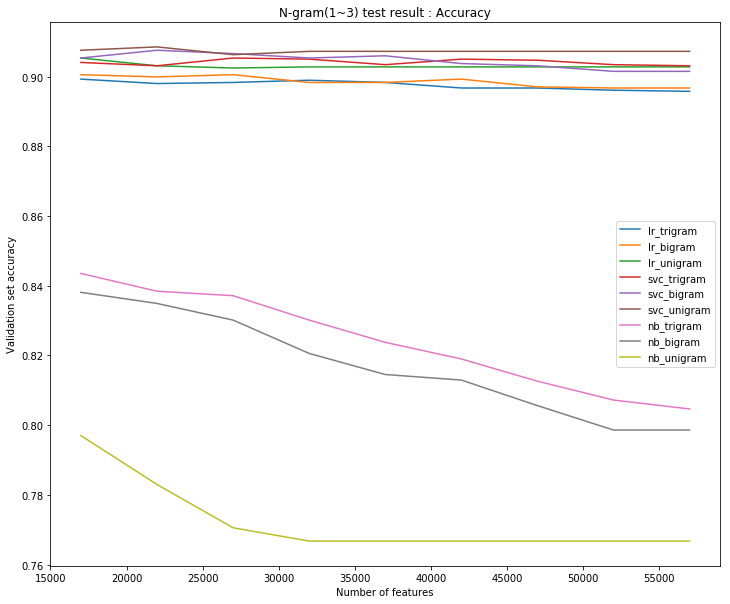

In [32]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_tg = pd.DataFrame(svc_feature_result_tg,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_bg = pd.DataFrame(svc_feature_result_bg,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_ug = pd.DataFrame(svc_feature_result_ug,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_tg = pd.DataFrame(nb_feature_result_tg,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_bg = pd.DataFrame(nb_feature_result_bg,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_ug = pd.DataFrame(nb_feature_result_ug,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(12,10))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='lr_trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='lr_bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='lr_unigram')
plt.plot(svc_nfeatures_plot_tg.nfeatures, svc_nfeatures_plot_tg.validation_accuracy,label='svc_trigram')
plt.plot(svc_nfeatures_plot_bg.nfeatures, svc_nfeatures_plot_bg.validation_accuracy,label='svc_bigram')
plt.plot(svc_nfeatures_plot_ug.nfeatures, svc_nfeatures_plot_ug.validation_accuracy, label='svc_unigram')
plt.plot(nb_nfeatures_plot_tg.nfeatures, nb_nfeatures_plot_tg.validation_accuracy,label='nb_trigram')
plt.plot(nb_nfeatures_plot_bg.nfeatures, nb_nfeatures_plot_bg.validation_accuracy,label='nb_bigram')
plt.plot(nb_nfeatures_plot_ug.nfeatures, nb_nfeatures_plot_ug.validation_accuracy, label='nb_unigram')

plt.title("N-gram(1~3) test result : Accuracy")

plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# Accuracy using CountVectorizer and LinearSVC

In [33]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
svc_feature_result_wosw, svc_u_checker_pipeline = nfeature_accuracy_checker(stop_words='english',classifier=svc)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.60%
model is 20.46% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.82%
model is 20.68% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.66%
model is 20.52% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.63%
model is 20.49% more accur

In [34]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
svc_feature_result_ug, svc_u_checker_pipeline = nfeature_accuracy_checker(classifier=svc)

RESULT FOR UNIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.92%
model is 20.78% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.66%
model is 20.52% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.47%
model is 20.33% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.47%
model is 20.33% more accurate

In [35]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
svc_feature_result_bg, svc_b_checker_pipeline = nfeature_accuracy_checker(classifier=svc,min_df=2,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 89.99%
model is 19.85% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.73%
model is 20.59% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.76%
model is 20.62% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.66%
model is 20.52% more accurate 

In [36]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
svc_feature_result_tg, svc_t_checker_pipeline = nfeature_accuracy_checker(classifier=svc,min_df=2,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 89.61%
model is 19.47% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 89.99%
model is 19.85% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.18%
model is 20.04% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.31%
model is 20.17% more accurate

# Accuracy using CountVectorizer Multinomial Naive Byes

In [37]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
nb_feature_result_wosw, nb_u_checker_pipeline = nfeature_accuracy_checker(stop_words='english',classifier=nb)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 85.63%
model is 15.49% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 85.18%
model is 15.04% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 84.77%
model is 14.63% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 84.93%
model is 14.79% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 

In [38]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
nb_feature_result_ug, nb_u_checker_pipeline = nfeature_accuracy_checker(classifier=nb)

RESULT FOR UNIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 86.23%
model is 16.09% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 86.20%
model is 16.06% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 86.11%
model is 15.97% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 86.11%
model is 15.97% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 70.

In [39]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
nb_feature_result_bg, nb_b_checker_pipeline = nfeature_accuracy_checker(classifier=nb,min_df=2,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 87.00%
model is 16.86% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 87.25%
model is 17.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 87.32%
model is 17.18% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 87.41%
model is 17.27% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 70.1

In [40]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
nb_feature_result_tg, nb_t_checker_pipeline = nfeature_accuracy_checker(classifier=nb,min_df=2,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 87.09%
model is 16.95% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 86.97%
model is 16.83% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 87.22%
model is 17.08% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 87.16%
model is 17.02% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 37000 features
null accuracy: 70.

# Accuracy using CountVectorizer Linear Regression

In [41]:
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw, u_checker_pipeline = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 91.52%
model is 21.38% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 91.59%
model is 21.45% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 91.65%
model is 21.51% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%

In [42]:
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug, u_checker_pipeline = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 91.49%
model is 21.35% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 91.52%
model is 21.38% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 91.30%
model is 21.16% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
ac

In [43]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg, b_checker_pipeline = nfeature_accuracy_checker(min_df=2,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.98%
model is 20.84% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.95%
model is 20.81% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.95%
model is 20.81% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
acc

In [44]:
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg, t_checker_pipeline = nfeature_accuracy_checker(min_df=2,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.98%
model is 20.84% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.95%
model is 20.81% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 91.17%
model is 21.03% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
ac

# Accuracy Comparion for Unigram and Bigram

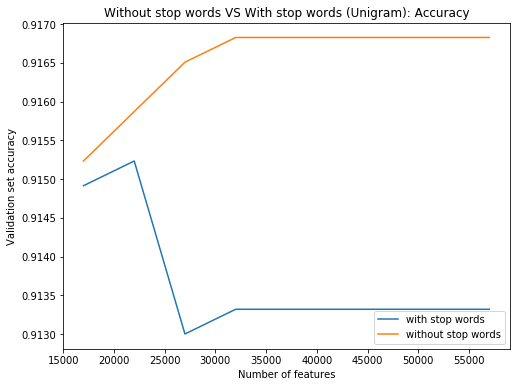

In [45]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

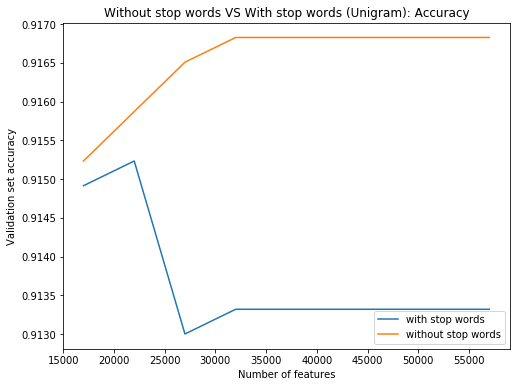

In [46]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# Accuracy Comparion using Count Vectorizer

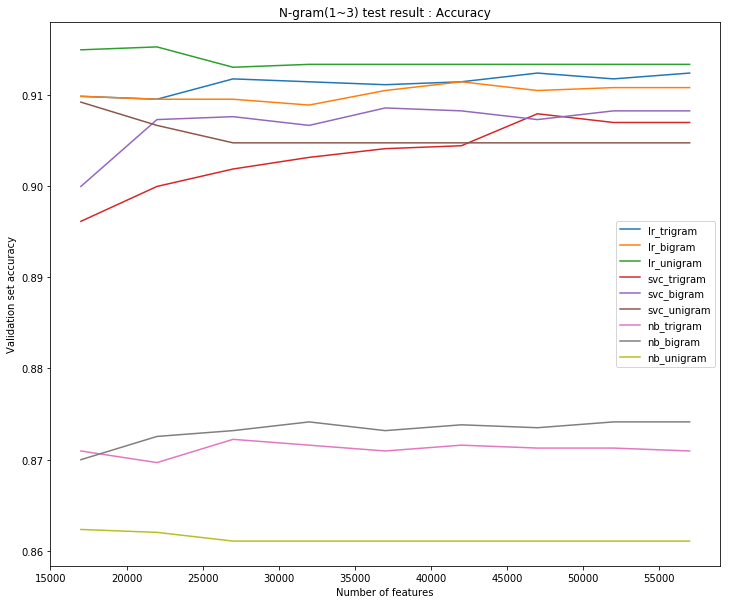

In [47]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_tg = pd.DataFrame(svc_feature_result_tg,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_bg = pd.DataFrame(svc_feature_result_bg,columns=['nfeatures','validation_accuracy'])
svc_nfeatures_plot_ug = pd.DataFrame(svc_feature_result_ug,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_tg = pd.DataFrame(nb_feature_result_tg,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_bg = pd.DataFrame(nb_feature_result_bg,columns=['nfeatures','validation_accuracy'])
nb_nfeatures_plot_ug = pd.DataFrame(nb_feature_result_ug,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(12,10))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='lr_trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='lr_bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='lr_unigram')
plt.plot(svc_nfeatures_plot_tg.nfeatures, svc_nfeatures_plot_tg.validation_accuracy,label='svc_trigram')
plt.plot(svc_nfeatures_plot_bg.nfeatures, svc_nfeatures_plot_bg.validation_accuracy,label='svc_bigram')
plt.plot(svc_nfeatures_plot_ug.nfeatures, svc_nfeatures_plot_ug.validation_accuracy, label='svc_unigram')
plt.plot(nb_nfeatures_plot_tg.nfeatures, nb_nfeatures_plot_tg.validation_accuracy,label='nb_trigram')
plt.plot(nb_nfeatures_plot_bg.nfeatures, nb_nfeatures_plot_bg.validation_accuracy,label='nb_bigram')
plt.plot(nb_nfeatures_plot_ug.nfeatures, nb_nfeatures_plot_ug.validation_accuracy, label='nb_unigram')

plt.title("N-gram(1~3) test result : Accuracy")

plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [48]:
feature_result_ugt, u_checker_pipeline_tfidf = nfeature_accuracy_checker(vectorizer=tvec)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.54%
model is 20.40% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 90.31%
model is 20.17% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 90.25%
model is 20.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 90.28%
model is 20.14%

In [49]:
feature_result_tgt, u_checker_pipeline_tfidf_stopwords = nfeature_accuracy_checker(stop_words='english',vectorizer=tvec,ngram_range=(1, 3))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 91.40%
model is 21.26% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 91.33%
model is 21.19% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 91.30%
model is 21.16% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 91.20%
model is 21.06%

In [50]:
feature_result_bgt, b_checker_pipeline_tfidf = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 90.03%
model is 19.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 89.87%
model is 19.73% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 89.93%
model is 19.79% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 89.87%
model is 19.73%

In [51]:
feature_result_tgt, t_checker_pipeline_tfidf = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 17000 features
null accuracy: 70.14%
accuracy score: 89.87%
model is 19.73% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 22000 features
null accuracy: 70.14%
accuracy score: 89.80%
model is 19.66% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 27000 features
null accuracy: 70.14%
accuracy score: 89.87%
model is 19.73% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 32000 features
null accuracy: 70.14%
accuracy score: 89.71%
model is 19.57%

In [52]:
print(feature_result_tgt)

[(17000, 0.8986615678776291), (22000, 0.8980242192479286), (27000, 0.8986615678776291), (32000, 0.897068196303378), (37000, 0.8980242192479286), (42000, 0.8973868706182282), (47000, 0.8961121733588273), (52000, 0.8951561504142767), (57000, 0.8957934990439771)]


# Accuracy Comparison using Logistic Regression for unigram, bigram and trigram

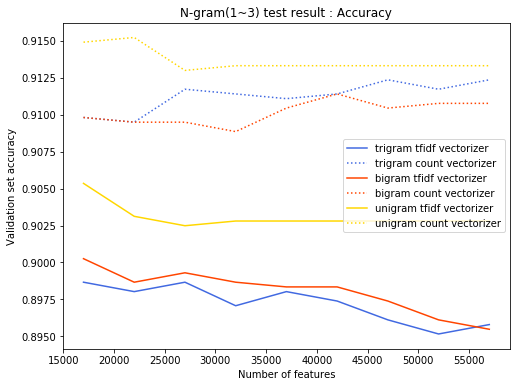

In [53]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# Tweets Processing using tweepy

In [ ]:
app = Flask(__name__) # __name__ is just the name of the module
abc = 0
## Twitter Clients ###
class TwitterClients():
    def __init__(self,twitter_user=None):
        self.auth = TwitterAutheticator().authenticateTwitterApp()
        self.twitter_client = API(self.auth)
        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client


    def get_user_timeline_tweets(self,num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline,id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

### Twitter Authenticator 
class TwitterAutheticator():
    def authenticateTwitterApp(self):
        auth = OAuthHandler(TwitterCredential.CONSUMER_KEY, TwitterCredential.CONSUMER_SECRET) #OAuthHandler Class which we are importing from tweepy which is responsible for authenticating code
        auth.set_access_token(TwitterCredential.ACCESS_TOKEN,TwitterCredential.ACCESS_TOKEN_SECRET);
        return auth

class TwitterStreamer():
    '''
    Class for streaming and processing live stream
    '''
    
    def __init__(self):
        self.twitter_auth = TwitterAutheticator()
    def stream_tweets(self, fetched_tweet_filename, hash_tag_list):
        # This haldles twitter authentication and the connection to twitter connection API
        listener = TwitterListener(fetched_tweet_filename)  # Object of the class we have created
        auth = self.twitter_auth.authenticateTwitterApp()
        stream = Stream(auth,listener);
        stream.filter(track=hash_tag_list);
class TwitterListener(StreamListener):  #SthatreamListener Provides Methods We can Override that is why it is inherited
#This is basic listener class that just prints received prints to stdout
    def __init__(self,fetched_tweets_fileName):
        self.fetched_tweets_fileName = fetched_tweets_fileName
        
    def on_data(self, data):    #It is overridden method it will take data as it is getting tweets 
        try:
            print(data)
            with open(self.fetched_tweets_fileName,'a') as tf:
                tf.write((data))
            return True
        except Exception as e:
            print("Error on data: %s" %str(e))
            return True
    def on_error(self, status):
        if status == 420:
            return False
            #Returning False on_data method in case rate limit is occurs 
        print(status)

class TweetAnalyzer():
    global abc
    dict = {}
#Functionalities for analyzing and categorizing content from tweets
    def tweets_to_data_frame(self,tweets):
        df = pd.DataFrame(data = [tweet.text for tweet in tweets], columns = ['Tweets'])
        return df
    @app.route('/')
    def index():
        return render_template('index.html')
    @app.route('/aboutUs', methods=['GET','POST'])
    def about():
        return render_template('aboutUs.html')
    @app.route("/resultOfDict", methods=['GET','POST'])
    def resultOfDict():
        if request.method == 'POST':
            result = request.form['text']
            clean_tweets,u_ans = answer(result)    
        return render_template("resultOfDict.html",clean_tweets = clean_tweets, u_ans = u_ans)

def answer(abc):
    twitter_client = TwitterClients()
    api = twitter_client.get_twitter_client_api()
    tweet_analyzer = TweetAnalyzer()           
    tweets = tweepy.Cursor(api.search, q='#'+abc, rpp=100).items(50)
    df_tweet = tweet_analyzer.tweets_to_data_frame(tweets)
    print('printing head')
    print(df_tweet.head())
    clean_tweets = []   # a list
    for i in range(len(df_tweet)):
        clean_tweets.append(text_cleaner(df_tweet['Tweets'][i]))
    
    print('Result of My Tweet:\n')
    u_ans = u_checker_pipeline.predict(clean_tweets)
    print(u_ans)
    for i in range(len(u_ans)):
        if u_ans[i]==1:
            print(clean_tweets[i])

    print('done')
    neg = np.count_nonzero(u_ans == 1)
    final = []
    final.append(neg)
    final.append(len(u_ans)-neg)
    output_notebook()
    an = ['Negative', 'Neutral']

    p = figure(x_range=an, plot_height=250, title="Hate Speech",
               toolbar_location="right")

    p.vbar(x=an, top=final, width=0.3)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0

    show(p)
    return(clean_tweets,u_ans)


if __name__ == "__main__":
    from werkzeug.serving import run_simple
    run_simple('localhost', 5000, app)
#     th1 = threading.Thread(target=run_simple, args=('localhost', 9003,app),daemon=True)
#     th1.start()
    app.debug = True # For Debugging Purpose Only
    

 * Running on http://localhost:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Dec/2018 21:29:46] "GET / HTTP/1.1" 200 -
[2018-12-14 21:29:50,580] ERROR in app: Exception on /resultOfDict [POST]
Traceback (most recent call last):
  File "C:\Users\nitis\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 2292, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\nitis\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 1815, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\nitis\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 1718, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\nitis\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\_compat.py", line 35, in reraise
    raise value
  File "C:\Users\nitis\AppData\Local\Continuum\anaconda3\lib\site-packages\flask\app.py", line 1813, in full_dispatch_request
    rv = self.dispatch_request

printing head
Empty DataFrame
Columns: [Tweets]
Index: []
Result of My Tweet:



127.0.0.1 - - [14/Dec/2018 21:29:52] "GET / HTTP/1.1" 200 -


printing head
                                              Tweets
0  #sad #realDonaldTrump #faketweets: RT realDona...
1  RT @JayMyersDocs: Today’s POPQUIZ! Which of th...
2  RT @markinjax: #RealCandaceO #Charliekirk11 #B...
3  #sad #realDonaldTrump #faketweets: Wow, but no...
4  #sad #realDonaldTrump #faketweets: RT realDona...
Result of My Tweet:

[0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 0 1 1 1 0 1 1 0]
realcandaceo charliekirk benshapiro laryelder diamondandsilk how does this video only have a quarter million views
sad realdonaldtrump faketweets realdonaldtrump as i predicted all along obamacare has been struck down as
sad realdonaldtrump faketweets realdonaldtrump for the record there were many people who wanted to be the
realdonaldtrump last man standing admin
sad realdonaldtrump faketweets as i predicted all along obamacare has been struck down as an unconstitutional
my gratitude to my iowa ag leadership committees who worked with me

Loading BokehJS ...

127.0.0.1 - - [14/Dec/2018 21:29:57] "POST /resultOfDict HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2018 21:30:35] "GET / HTTP/1.1" 200 -


printing head
                                              Tweets
0                #Nigga #BLM https://t.co/A2QMijoxpS
1  #Oldie but a goodie... @lifttheveil411 not tha...
2  Ñaum Ñaum!!! 🌰🍮🎂👴🏿#nigga #cupcakes #mierda htt...
3  Sambarockando ❤️\n.\n.\n.\n#goodnight #summer ...
4  Hj me chame de plano de saúde q eu vou tirar s...
Result of My Tweet:

[1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 0 1 1 1 1 1]
nigga blm
oldie but a goodie not that smart or original it s chrishanson craigshurter confused
aum aum nigga cupcakes mierda
sambarockando goodnight summer ilove ilovemyhair blackpower faladorpassamal nigga sambarock
hj me chame de plano de sa de q eu vou tirar sua car ncia negro istagram facebook juizdefora
shiny stadium picoftheday picofthenight cool men menstyles mexican mexico selfie pawnigga vans
lo que la vida te no es lo que quieres si no lo que tu alma necesita futbol soccer blessed
i look like a artist who gone make it real big o

Loading BokehJS ...

127.0.0.1 - - [14/Dec/2018 21:30:39] "POST /resultOfDict HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2018 21:31:00] "GET / HTTP/1.1" 200 -


printing head
                                              Tweets
0  PornHub, but with Live Webcams: https://t.co/3...
1  RT @Natalie77488833: Comment if you actually l...
2  ♥️ @xvideosmilfs ♥️\n\n➡️https://t.co/tvltcEby...
3  La milf Sara Jay se folla a un ladrón\n\n➡️htt...
4  ♥️ @xvideosmilfs ♥️\n\n➡️https://t.co/tvltcEby...
Result of My Tweet:

[0 1 1 1 1 1 1 1 1 1 1]
comment if you actually like me and i ll start posting again jailbait teen young underage boobs naked cutie pe
porno de maduras gif gifts porn sex xxx adult ass
la milf sara jay se folla a un ladr n porno de maduras gif gifts porn sex
porno de maduras gif gifts porn sex xxx adult ass
porno de maduras gif gifts porn sex xxx adult ass
white girl dped by bbcs to pay off her boyfriend s debt pussy tits
do what i want and i ll be all yours young daddy cumtribute teen virgin nude spanking choking feet fetish
retweet dm me if you horny horny boobs tits pussy porn amateurporn nsfw cumslut blowjob sex slut a
retweet if you d

Loading BokehJS ...

127.0.0.1 - - [14/Dec/2018 21:31:05] "POST /resultOfDict HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2018 21:31:25] "GET / HTTP/1.1" 200 -


printing head
                                              Tweets
0                Rise above #HATE\nRise above #PRIDE
1  Promote awareness of #NanjingMassacre , elimin...
2  RT @schwingcat: @IlhanMN #Hate is a Democrat v...
3  THEIR IS AN ENEMY AMONG US; LOL 😂🤣😂 IT’S MY DA...
4  Why do you #hate poor Americans and legal immi...
Result of My Tweet:

[1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 0 0 1 0 1 0 1 1 1 1]
rise above hate rise above pride
promote awareness of nanjingmassacre eliminate hate work for peace
hate is a democrat value
their is an enemy among us lol it s my damn stomach lmao funnymemes funnyvideos tumblr instagram
why do you hate poor americans and legal immigrants
just found a group of african midgets time to commit a hate crime
love lies there poem poetry poet audio art words wordsmith poetrypublisher artist writer bookworm
this is hate in a natzi form what is wrong with humanity why can not we agree to love others as much as we

Loading BokehJS ...

127.0.0.1 - - [14/Dec/2018 21:31:30] "POST /resultOfDict HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2018 21:31:35] "GET / HTTP/1.1" 200 -


printing head
                                              Tweets
0  RT @joy23087210: RETWEET  😍🍑 DM me if you’re h...
1   sorry. All my best tweets contain the word #fuck
2  ♥️ @xvideosmilfs ♥️\n\n➡️https://t.co/tvltcDTX...
3  ♥️ @xvideosmilfs ♥️\n\n➡️https://t.co/tvltcEby...
4  ♥️ @xvideosmilfs ♥️\n\n➡️https://t.co/tvltcEby...
Result of My Tweet:

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
retweet dm me if you horny horny boobs tits pussy porn amateurporn nsfw cumslut blowjob sex slut a
sorry all my best tweets contain the word fuck
porno de maduras gif gifts porn sex xxx adult ass
porno de maduras gif gifts porn sex xxx adult ass
porno de maduras gif gifts porn sex xxx adult ass
porno de maduras gif gifts porn sex xxx adult ass
porno de maduras gif gifts porn sex xxx adult ass
no he ido a pagar la luz fuck
any guys want to spoil me add me on kik dirtybabe penis dmme tits cuckold feetpics brunette add bigcock
porno de maduras gif gifts porn sex xxx adult ass
la milf sara jay se folla a

Loading BokehJS ...

127.0.0.1 - - [14/Dec/2018 21:31:47] "POST /resultOfDict HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2018 21:31:54] "GET / HTTP/1.1" 200 -


printing head
                                              Tweets
0  I'm just so fucking horny rn, god 😩😳 #Horny #S...
1  Got a big ass? Dm me rn to see my fat cock🔥 #f...
2  Reversability of fluid motion •\n•\n•\n•\n•\n#...
3  Clap while reading this #powerful #bitch 💀💀 ht...
4  Whoppin till I'm #Winnin, my niggaz been my ni...
Result of My Tweet:

[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1]
reversability of fluid motion bitch science jerk biology physics nasa atheist atheism astronomy
cosplaying kenzi from lostgirl the other weekend with my dear friend who i fondly call
what s my purpose bitch
stay true to your word can t stand people who don t gonna have to cut you off now bitch
join the the busy mommas facebook chat latest post how much does the tooth fairy pay
bitch
when i got to the gym and a dude s muscles are bigger than mine i just tell myself how much farther i could hit a golf
have you heard acapella fella new remix of madonna ray of light at np soundcloud

Loading BokehJS ...

127.0.0.1 - - [14/Dec/2018 21:32:03] "POST /resultOfDict HTTP/1.1" 200 -
127.0.0.1 - - [14/Dec/2018 21:33:01] "GET / HTTP/1.1" 200 -
